In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [2]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [3]:
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
df.shape

(42, 2)

In [5]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

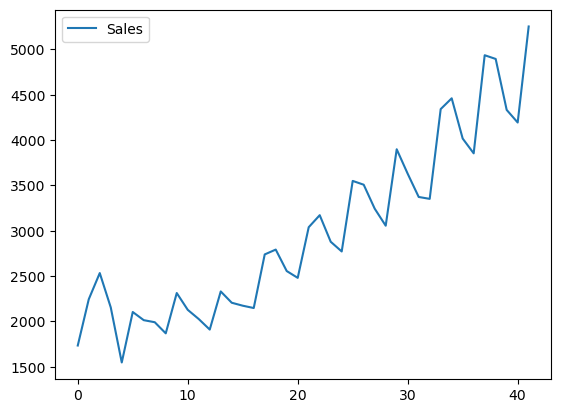

In [6]:
df.plot()
plt.show()

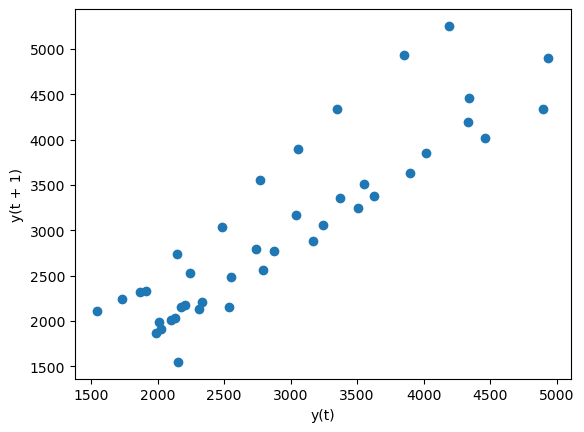

In [7]:
lag_plot(df['Sales'])
plt.show()

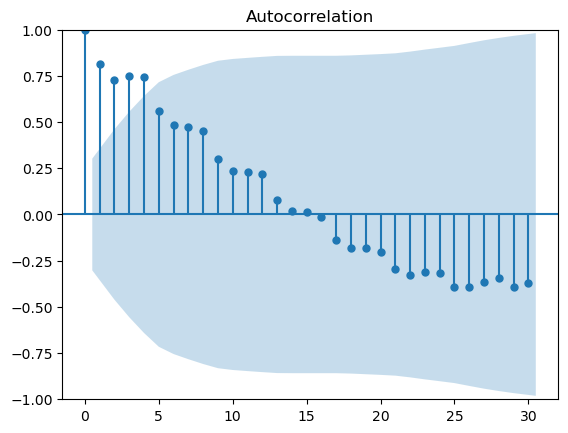

In [8]:
plot_acf(df['Sales'],lags=30)
plt.show()

In [9]:
df['Quarters']=df['Quarter'].str.extract(r'(\w{2})',expand=False)
df['Years']=df['Quarter'].str.extract(r'(\d{2})',expand=False)

In [10]:
df.head()

,Quarter,Sales,Quarters,Years
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [11]:
quat_dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df = pd.concat([df,quat_dummy],axis=1)
df.head()

,Quarter,Sales,Quarters,Years,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


<AxesSubplot:xlabel='Quarters', ylabel='Years'>

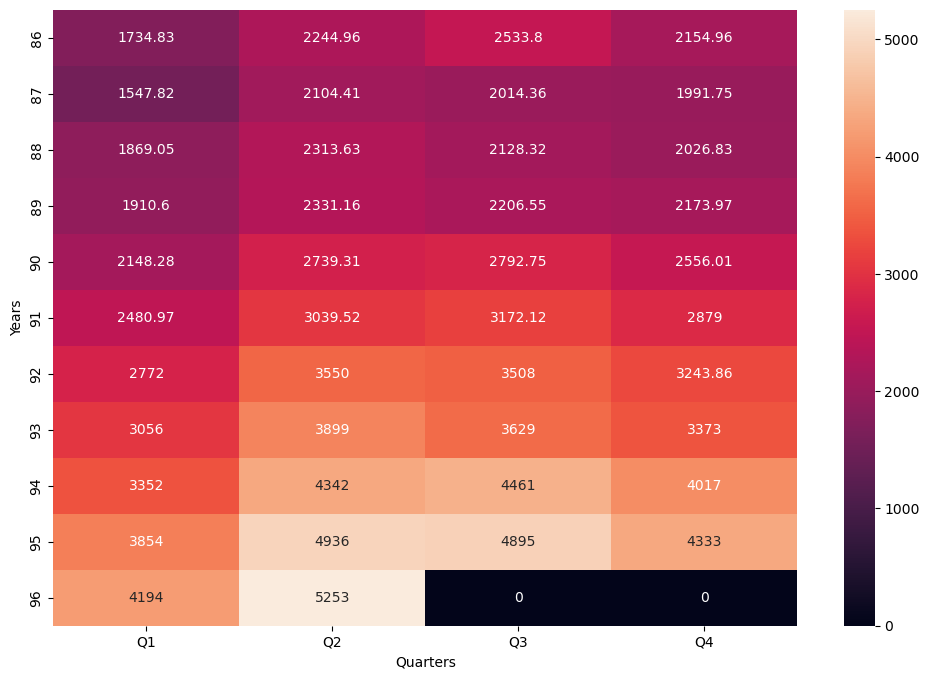

In [12]:
plt.figure(figsize=(12,8))
heatmap_quarter = pd.pivot_table(data=df,values='Sales',index='Years',columns='Quarters',aggfunc='mean',fill_value=0)
sns.heatmap(heatmap_quarter,annot=True,fmt='g')

<AxesSubplot:xlabel='Years', ylabel='Sales'>

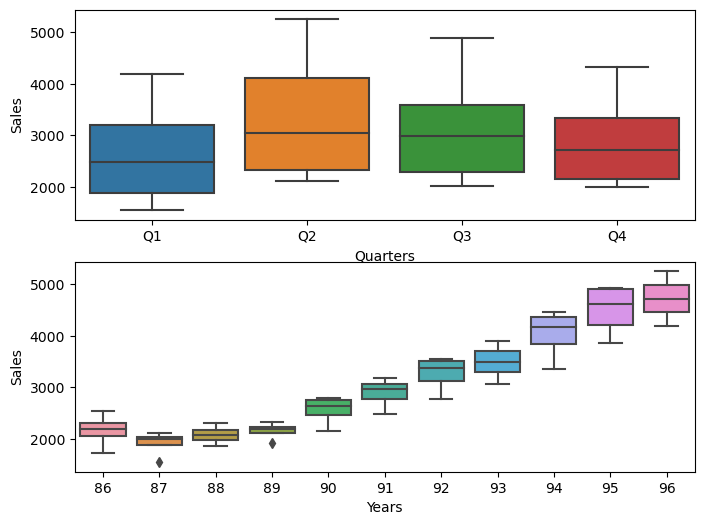

In [13]:
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="Quarters",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="Years",y="Sales",data=df)


In [14]:
import numpy as np
df['t']=range(1,43)
df['t_squared']=df['t']*df['t']
df['log_sales']=np.log(df['Sales'])
df.head()

,Quarter,Sales,Quarters,Years,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


## Splitting Data

In [15]:
Train = df.head(38)
Test = df.tail(4)

In [16]:
Test

,Quarter,Sales,Quarters,Years,Q1,Q2,Q3,Q4,t,t_squared,log_sales
38,Q3_95,4895.0,Q3,95,0,0,1,0,39,1521,8.495970
39,Q4_95,4333.0,Q4,95,0,0,0,1,40,1600,8.374015
40,Q1_96,4194.0,Q1,96,1,0,0,0,41,1681,8.341410
41,Q2_96,5253.0,Q2,96,0,1,0,0,42,1764,8.566555


### Model Based Approach

In [17]:
# Linear Model 
import statsmodels.formula.api as smf 
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

591.553295722396

In [18]:
# Exponential 
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

466.2479731067161

In [19]:
# Quadratic
quad_model = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_quad = pd.Series(quad_model.predict(Test[['t','t_squared']]))
rmse_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_quad))**2))
rmse_quad

475.5618351831504

In [20]:
# Additive Seasonality 
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1860.023815454728

In [21]:
#Additive Seasonality Quadratic
add_sea_quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(Test[['Q1','Q2','Q3','Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad


301.73800719347366

In [22]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

225.52439049827785

In [23]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_exp","rmse_quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
5,rmse_Mult_add_sea,225.524390
4,rmse_add_sea_quad,301.738007
1,rmse_exp,466.247973
2,rmse_quad,475.561835
0,rmse_linear,591.553296
3,rmse_add_sea,1860.023815


## Multiplicative additive seasonality  has the least rms value compared to other models So, that can be used for Forecasting..

## ARIMA

In [24]:
from pmdarima.arima import auto_arima


In [25]:
model = auto_arima(Train['Sales'],start_p=0,
                              start_q=0,max_p=10,max_q=10,
                              m=12,start_P=0,seasonal=True,
                              d=1,D=1,trace=True,error_action="ignore",
                              suppress_warnings= True,
                              stepwise=False)


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=348.791, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=350.515, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=352.290, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=350.496, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=352.423, Time=0.07 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=352.318, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=350.787, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=352.500, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=354.259, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=352.478, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=356.161, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[12]  

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   38
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -173.396
Date:                            Mon, 03 Jul 2023   AIC                            348.791
Time:                                    18:31:42   BIC                            350.010
Sample:                                         0   HQIC                           349.129
                                             - 38                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.191e+04   1.95e+04      3.180      0.001    2.37e+04       1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.87   Prob(JB):                         0.74
Heteroskedasticity (H):               0.58   Skew:                             0.23
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
def MAPE(pred,org):
    passenger = np.abs((pred-org))*100/org
    return np.mean(passenger)

In [28]:
pred_test = model.predict(n_periods=12)

In [29]:
MAPE(pred_test,Test.Sales)

3.348489074643977

In [30]:
## SARIMa
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
model_sa =SARIMAX(df['Sales'],order=(3,1,0),seasonal_order=(1,1,1,12))
results = model_sa.fit()
df['forecast']=results.predict(start=5,end=200,dynamic=True)

C:\Users\Sudeep\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                   42
Model:             SARIMAX(3, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -196.784
Date:                              Mon, 03 Jul 2023   AIC                            405.568
Time:                                      18:31:43   BIC                            413.771
Sample:                                           0   HQIC                           408.137
                                               - 42                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0356      0.220      0.162      0.872      -0.396       0.467
ar.L2         -0.5554      0.163     -3.407      0.001      -0.875      -0.236
ar.L3         -0.0286      0.202     -0.141      0.887      -0.424       0.367
ar.S.L12      -0.5369      1.425     -0.377      0.706      -3.329       2.256
ma.S.L12       0.1394      1.744      0.080      0.936      -3.278       3.557
sigma2      4.092e+04   1.49e+04      2.756      0.006    1.18e+04       7e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.35   Prob(JB):                         0.84
Heteroskedasticity (H):               0.53   Skew:                            -0.15
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

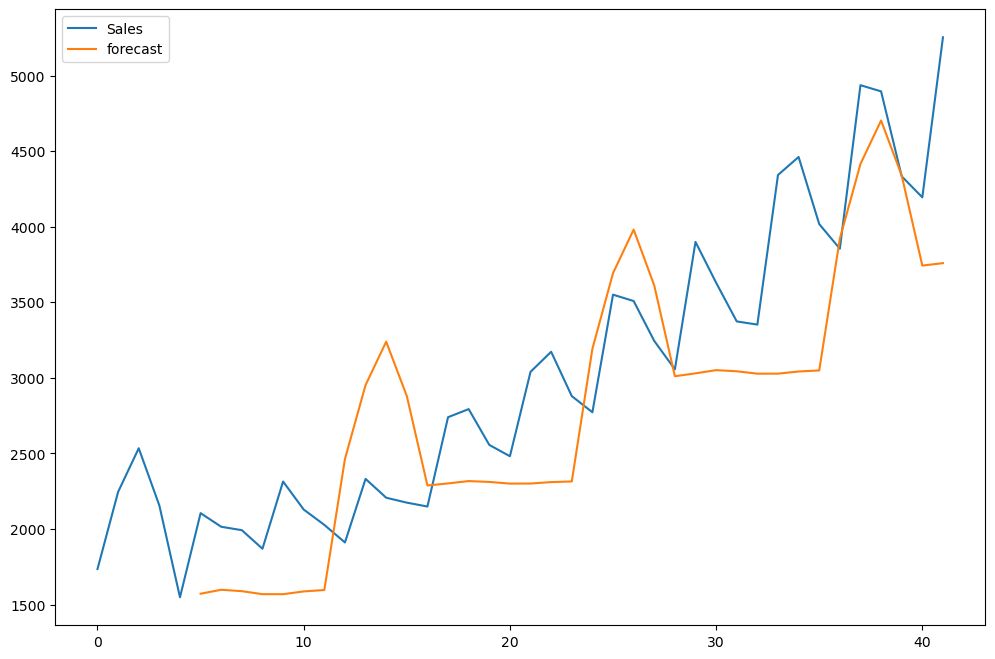

In [32]:
df[['Sales','forecast']].plot(figsize=(12,8))
results.summary()